In [65]:
import pandas as pd
import numpy as np
import os
import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
os.getcwd()
df = pd.read_csv("data/SeriesReport-Not Seasonally Adjusted Sales - Monthly (Millions of Dollars).csv")
df["Period"] = pd.to_datetime(df["Period"])

In [3]:
# Historical data (1992 - 2018)
df_train = df[(df["Period"] < datetime.datetime(2019,1,1))]

In [4]:
# Test data (2019)
df_test = df[(df["Period"] >= datetime.datetime(2019,1,1)) & (df["Period"] <= datetime.datetime(2019,12,1))]

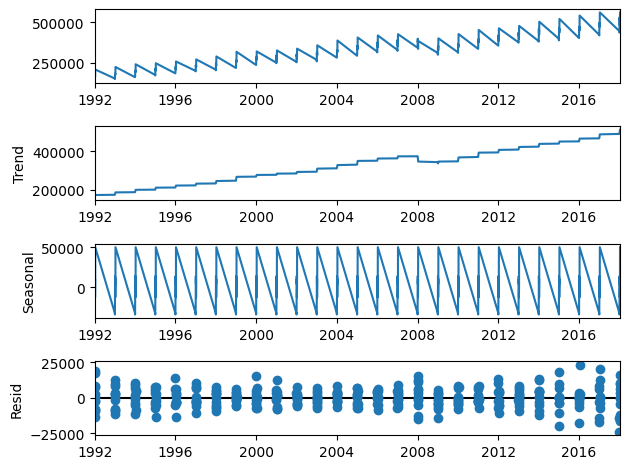

In [104]:
# Seasonal Decompose
from statsmodels.tsa.seasonal import seasonal_decompose
df_series = pd.Series(df_train["Value"].to_list(), index = df_train["Period"])
df_series.index = pd.to_datetime(df_series.index)
result = seasonal_decompose(df_series, model='ad',period=12, extrapolate_trend=12)
fig = result.plot()

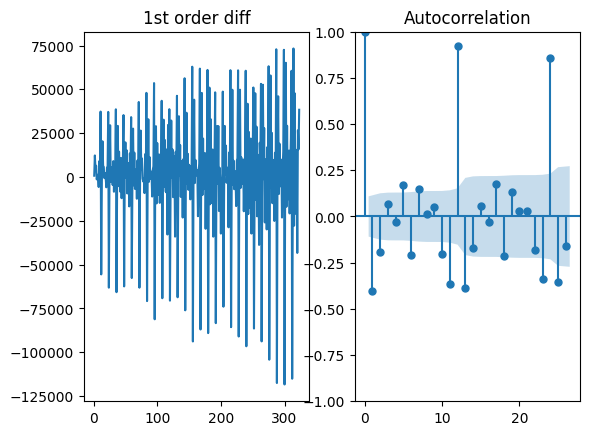

In [105]:
# 1st order differentiation

from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import figure
import matplotlib.pyplot as plt
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('1st order diff')
ax1.plot(df_train["Value"].diff())

ax2 = f.add_subplot(122)
plot_acf(df_train["Value"].diff().dropna(),ax=ax2)
plt.show()

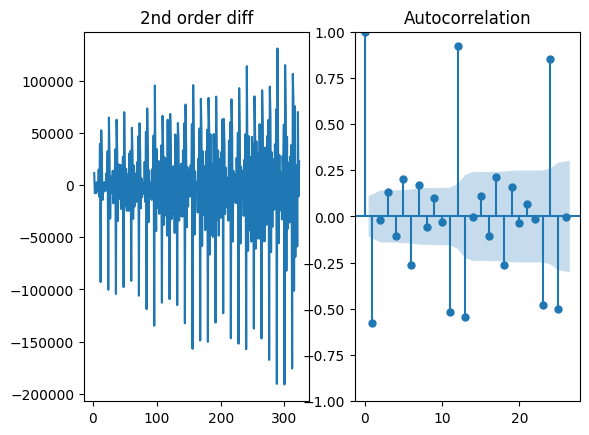

In [106]:
# 2nd order differentiation

f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('2nd order diff')
ax1.plot(df_train["Value"].diff().diff())

ax2 = f.add_subplot(122)
plot_acf(df_train["Value"].diff().diff().dropna(),ax=ax2)
plt.show()

In [108]:
# Adfuller test
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_train["Value"])
print('p-value: ',result[1])
result = adfuller(df_train["Value"].diff().dropna())
print('p-value: ',result[1])

p-value:  0.9336399865193739
p-value:  0.0009509562979706774


In [117]:
from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(df_train["Value"], order=(1,1,2), seasonal_order=(1,1,1,12))
model = arima_model.fit()
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Value   No. Observations:                  324
Model:             ARIMA(1, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -3227.054
Date:                            Thu, 15 Dec 2022   AIC                           6466.108
Time:                                    17:17:09   BIC                           6488.547
Sample:                                         0   HQIC                          6475.077
                                            - 324                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6355      0.238     -2.674      0.008      -1.101      -0.170
ma.L1          0.4627      0.243   

In [118]:
y_pred = pd.Series(model.forecast(12).to_list(), index = df_test["Period"])
y_true = pd.Series(df_test["Value"].to_list(), index = df_test["Period"])

In [119]:
mae = np.mean(np.abs(y_pred - y_true))
rmse = np.mean((y_pred - y_true)**2)**.5

In [120]:
print(mae)
print(rmse)

12432.826395047747
14504.625872314004


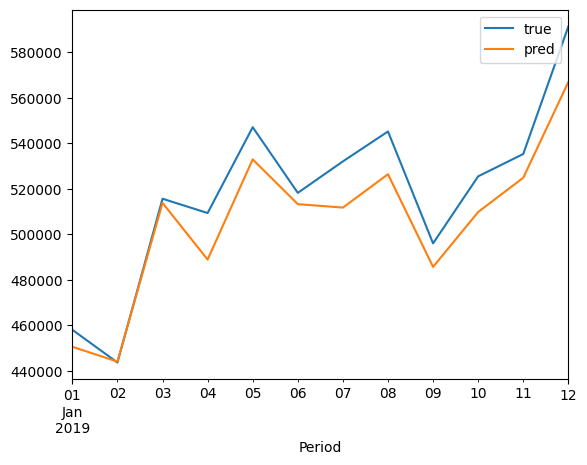

In [121]:
from matplotlib import figure
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax = y_true.plot(ax=ax,label='true')
ay = y_pred.plot(ax=ax,label='pred')
ax.legend(loc="upper right")
#fig = plot_predict(model,dynamic=False, ax=ax,
#                        plot_insample=False)
plt.show()

In [122]:
def run_arima_parameters(order):
    arima_model = ARIMA(df_train["Value"], order=order, seasonal_order=(1,1,1,12))
    model = arima_model.fit()
    y_pred = pd.Series(model.forecast(12).to_list(), index = df_test["Period"])
    y_true = pd.Series(df_test["Value"].to_list(), index = df_test["Period"])
    rmse = np.mean((y_pred - y_true)**2)**.5
    return rmse,model

In [123]:
def evaluate_models(p_values,d_values,q_values):
    best_rmse, best_order = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                rmse,model = run_arima_parameters(order)
                print('RMSE: '+str(rmse),'Order: '+str(order))
                if rmse < best_rmse:
                    best_rmse, best_order = rmse,order
    print(best_rmse, best_order)
    return best_rmse, best_order
                        

In [68]:
# Running for different parameters
p_values = list(range(0,10))
d_values = list(range(0,3))
q_values = list(range(0,3))
evaluate_models(p_values,d_values,q_values)

RMSE: 9372.981520856629 Order: (0, 0, 0)
RMSE: 9717.82416526411 Order: (0, 0, 1)
RMSE: 1191789375.8098624 Order: (0, 0, 2)
RMSE: 19457.76328114889 Order: (0, 1, 0)
RMSE: 15541.103022979752 Order: (0, 1, 1)
RMSE: 14638.4216737269 Order: (0, 1, 2)
RMSE: 185160.50035585216 Order: (0, 2, 0)
RMSE: 21989.486992158465 Order: (0, 2, 1)
RMSE: 15207.48332036315 Order: (0, 2, 2)
RMSE: 9875.77675975907 Order: (1, 0, 0)
RMSE: 12593.949588216305 Order: (1, 0, 1)
RMSE: 11343.53981677066 Order: (1, 0, 2)
RMSE: 16606.895868757783 Order: (1, 1, 0)
RMSE: 14913.55321915051 Order: (1, 1, 1)
RMSE: 14504.625872314004 Order: (1, 1, 2)
RMSE: 146800.6848004881 Order: (1, 2, 0)
RMSE: 16052.474404626948 Order: (1, 2, 1)
RMSE: 22252.943573760163 Order: (1, 2, 2)
RMSE: 20008.11627603993 Order: (2, 0, 0)
RMSE: 10053.09263262262 Order: (2, 0, 1)
RMSE: 10570.707641365814 Order: (2, 0, 2)
RMSE: 14539.495975813914 Order: (2, 1, 0)
RMSE: 14486.662463439028 Order: (2, 1, 1)
RMSE: 16843.925913688898 Order: (2, 1, 2)
RMSE: 

(9372.981520856629, (0, 0, 0))

In [124]:
#Best model for RMSE with order (0,0,0)
from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(df_train["Value"], order=(0,0,0), seasonal_order=(1,1,1,12))
model = arima_model.fit()
y_pred = pd.Series(model.forecast(12).to_list(), index = df_test["Period"])
y_true = pd.Series(df_test["Value"].to_list(), index = df_test["Period"])

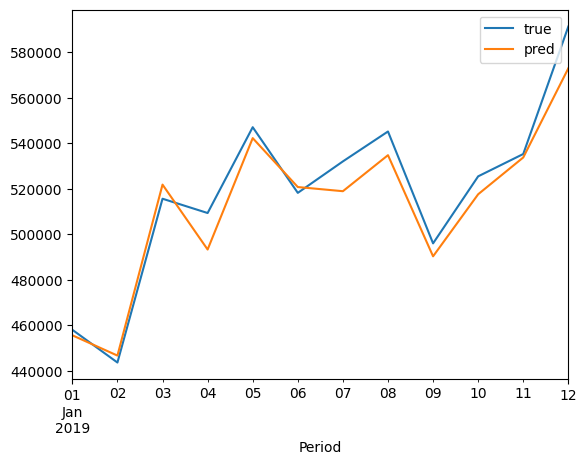

In [126]:
#Plotting real value vs predicted for 2019 (smaller RMSE than before)
from matplotlib import figure
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax = y_true.plot(ax=ax,label='true')
ay = y_pred.plot(ax=ax,label='pred')
ax.legend(loc="upper right")
plt.show()